<a href="https://colab.research.google.com/github/aniketjivani/generative_experiments/blob/master/2d_data_driven_advection_reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying to run 2D advection solvers from the Google repository on data-driven advection (see https://github.com/google-research/data-driven-advection/tree/master for details). The idea is to use these for passive scalar advection on white light image intensities. Then if needed, we can think about data-driven learning of discretization, decay function etc.

**Note**: Replace some of the `tf` commands in the original library. Most common fix: change `tf.contrib.framework.nest` to `tf.compat.v1.nest`. Similarly for any other commands that throw an error, go back and refer to https://www.tensorflow.org/api_docs/python/tf/compat/v1/ for replacements.

Needs fixing: `enable_eager_execution()`

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
!git clone https://github.com/google-research/data-driven-pdes
!pip install -e data-driven-pdes

fatal: destination path 'data-driven-pdes' already exists and is not an empty directory.
Obtaining file:///content/data-driven-pdes
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pde-superresolution-2d
    Found existing installation: pde-superresolution-2d 0.0.0
    Uninstalling pde-superresolution-2d-0.0.0:
      Successfully uninstalled pde-superresolution-2d-0.0.0
  Running setup.py develop for pde-superresolution-2d


In [3]:
os.getcwd()

'/content'

In [4]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'data-driven-pdes'))
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/content/data-driven-pdes', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/data-driven-pdes']


In [5]:
import matplotlib.pyplot as plt
import matplotlib

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
from google.colab import files  # colab-specific utilities; comment out when running locally

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()
# tf.enable_eager_execution()

# tf.__version__, tf.keras.__version__

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
# !bash tf_upgrade_v2 \
#   --intree data-driven-pdes/ \
#   --outtree data-driven-pdes-v2 \
#   --reportfile report.txt

In [9]:
import xarray
import datadrivenpdes as pde
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils

In [10]:
equation = pde.advection.equations.FiniteVolumeAdvectionDiffusion(diffusion_coefficient=0.01)
grid = grids.Grid.from_period(size=256, length=2*np.pi)

In [11]:
x, y = grid.get_mesh()

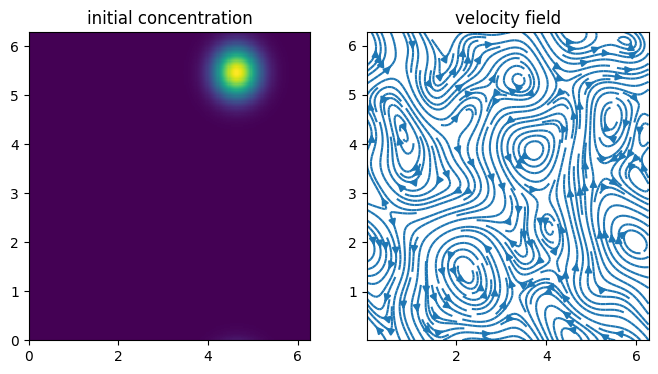

In [12]:
initial_state = equation.random_state(grid, seed=7109179)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].pcolor(grid.get_mesh()[1],
              grid.get_mesh()[0],
              initial_state['concentration'])
axs[0].set_title('initial concentration')

axs[1].streamplot(grid.get_mesh()[1],
                  grid.get_mesh()[0],
                  initial_state['y_velocity'],initial_state['x_velocity'],
                  density=2)
axs[1].set_title('velocity field');

In [13]:
print(initial_state.keys())

dict_keys(['concentration', 'x_velocity', 'y_velocity'])


In [14]:
time_step = equation.get_time_step(grid)
times = time_step*np.arange(400)
results = pde.core.integrate.integrate_times(
    model=pde.core.models.FiniteDifferenceModel(equation,grid),
    state=initial_state,
    times=times, axis=0)

Instructions for updating:
ksizes is deprecated, use sizes instead


In [15]:
results['concentration']

<tf.Tensor 'transpose:0' shape=(400, 256, 256) dtype=float32>

In [16]:
results

{'concentration': <tf.Tensor 'transpose:0' shape=(400, 256, 256) dtype=float32>,
 'x_velocity': <tf.Tensor 'transpose_1:0' shape=(400, 256, 256) dtype=float32>,
 'y_velocity': <tf.Tensor 'transpose_2:0' shape=(400, 256, 256) dtype=float32>}

In [23]:
# symbolic_tensor = tf.compat.v1.placeholder(tf.float32, shape=(400, 256, 256))
with tf.compat.v1.Session() as sess:
   concentration_tensor = sess.run(results['concentration'])

In [26]:
concentration_tensor.shape

(400, 256, 256)

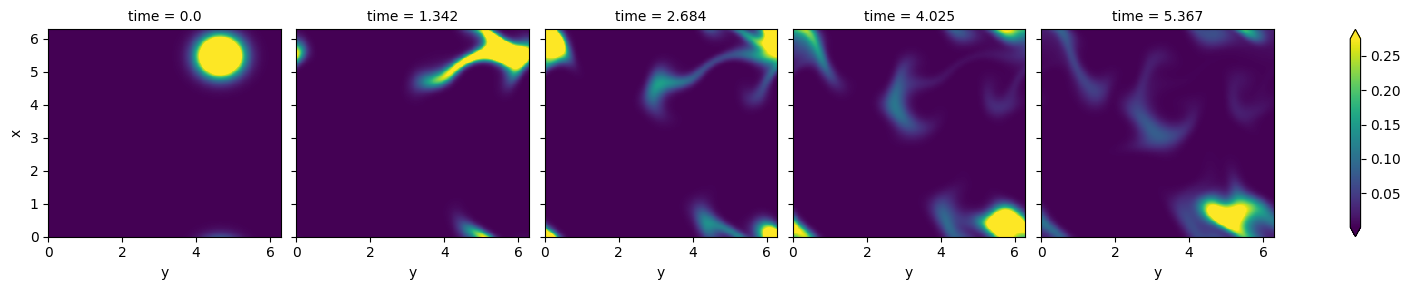

In [27]:
conc=xr.DataArray(concentration_tensor,
# conc=xr.DataArray(results['concentration'].numpy(),
                  dims=['time', 'x','y'],
                  coords={'time':times, 'x': x[:,0], 'y': y[0]}
                 )
conc[::99].plot(col='time', robust=True, aspect=1)